In [51]:
import utils
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import pandas as pd

In [169]:
vocab_size = 2000
train_size = 1000

# get the data set vocabulary
vocab = pd.read_table("../data/vocab.wiki.txt", header=None, sep="\s+", index_col=0, names=['count', 'freq'], )
num_to_word = dict(enumerate(vocab.index[:vocab_size]))
word_to_num = utils.invert_dict(num_to_word)

data_train = utils.load_np_dataset('../data/wiki-train.txt')
data_test = utils.load_np_dataset('../data/wiki-test.txt')

In [200]:
def process_data(data):
    y = [sent[0] for sent in data]
    x = [sent[1:] for sent in data]

    x_ = []
    for s in x:
        x_.append([word_to_num.get(w, word_to_num['UNK'])+1 for w in s])

    y_ = []
    for l in y:
        y_.append(0 if l == 'VBZ' else 1)

    x_ = pad_sequences(x_, maxlen=50)
    return x_, y_

x_train, y_train = process_data(data_train)
x_test, y_test = process_data(data_test)

In [201]:
x_train.shape, x_test.shape

((50000, 50), (4000, 50))

In [213]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Layer
from keras.layers import Embedding, Input
from keras.layers import LSTM, Bidirectional

from keras import initializers, regularizers, constraints
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np

'''
Adapted from gist: https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
'''
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

    
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self, return_attention=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.return_attention = return_attention

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        #ait = K.dot(uit, self.u)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        weighted_input = K.sum(weighted_input, axis=1)
        
        if self.return_attention:
            return [weighted_input, a]
        return weighted_input

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        output_len = input_shape[-1]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)
    

def get_model(max_length, vocab_size, trainable=True, 
              embedding_trainable=True,
              hidden_dim=100, return_attention=False):
    
    '''model = Sequential()
    model.add(Embedding(vocab_size, output_dim=256, 
                        trainable=embedding_trainable))
    model.add(LSTM(100, return_sequences=True, trainable=trainable))
    model.add(AttentionWithContext(name='att', trainable=trainable))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', trainable=trainable))'''
    
    input_ = Input(shape=(max_length,), dtype='float32')
    input_embed = Embedding(vocab_size+1, output_dim=200, mask_zero=True,
                            trainable=embedding_trainable,
                            name='embed')(input_)

    rnn_encoded = Bidirectional(LSTM(hidden_dim, return_sequences=True),
                                name='bidirectional',
                                merge_mode='concat',
                                trainable=trainable)(input_embed)
    '''rnn_encoded = LSTM(hidden_dim, return_sequences=True, 
                       trainable=trainable)(input_embed)'''

    x = AttentionWithContext(name='att', 
                             return_attention=return_attention,
                             trainable=trainable)(rnn_encoded)
    att = x
    if return_attention:
        x, att = x
    
    drop = Dropout(0.5)(x)
    y_hat = Dense(1, activation='sigmoid', trainable=trainable)(drop)
    outputs = [y_hat]
    
    if return_attention:
        outputs.append(att)
    
    model = Model(inputs=input_, outputs=outputs)
    model.summary()
    return model

model = get_model(50, vocab_size)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cp = ModelCheckpoint("../models/attention.{epoch:02d}-{val_loss:.2f}.hdf5",
                     monitor='val_loss',
                     verbose=0,
                     save_best_only=True,
                     save_weights_only=True,
                     mode='auto')
es = EarlyStopping(monitor='val_loss', patience=3)

# create a directory if it doesn't already exist
if not os.path.exists('../models'):
    os.makedirs('../models/')

train_size = 25000
model.fit(x_train[:train_size], y_train[:train_size], batch_size=16, epochs=10,
          callbacks=[cp, es], validation_split=.1)
score = model.evaluate(x_test, y_test, batch_size=16)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embed (Embedding)            (None, 50, 200)           400200    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           240800    
_________________________________________________________________
att (AttentionWithContext)   (None, 200)               40400     
_________________________________________________________________
dropout_42 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 201       
Total params: 681,601
Trainable params: 681,601
Non-trainable params: 0
_________________________________________________________________
Trai

In [214]:
weights_file = '../models/attention.25000.hdf5'
print('Weights loading from:', weights_file)

print('Loading models')
att_model = get_model(50, vocab_size, trainable=False,
                      embedding_trainable=False,
                      return_attention=True)

att_model.load_weights(weights_file, by_name=True)
#pred_model.compile(optimizer='adam', loss='categorical_crossentropy')


Weights loading from: ../weights/attention.25000.hdf5
Loading models
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embed (Embedding)            (None, 50, 200)           400200    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           240800    
_________________________________________________________________
att (AttentionWithContext)   [(None, 200), (None, 50)] 40400     
_________________________________________________________________
dropout_43 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 201       
Total params: 681,601
Trainable params: 0
Non-trainable params: 681,601
_

Sentence:  i think any such claim that mathematical physics VBZ large-scale tears in the fabric of NN definitely VBZ
Attention: [  1.34777008e-06   1.58498995e-06   4.46763479e-05   3.07296985e-04
   7.86230201e-04   4.24190424e-03   3.41895878e-01   5.79128206e-01
   1.19928522e-02   1.00436890e-02   4.50237244e-02   1.52072206e-03
   3.20734194e-04   3.25650978e-03   3.26481095e-04   5.29691388e-05
   1.05519325e-03]
Prediction: VBP
Sentence:  the only key posts indians have not held VBP
Attention: [ 0.00090677  0.0021646   0.00753049  0.36059043  0.55294591  0.03752809
  0.00541357  0.03291249]
Prediction: VBP
Sentence:  other notable examples VBP
Attention: [  6.70911628e-04   1.97903700e-02   9.79538679e-01]
Prediction: VBP
Sentence:  the eleven point river is a the river VBZ
Attention: [ 0.01036568  0.00235224  0.08502441  0.01950658  0.0030029   0.87171394
  0.00541001  0.00262405]
Prediction: VBZ
Sentence:  the rest VBZ
Attention: [ 0.26385087  0.73614895]
Prediction: VBZ
Sente

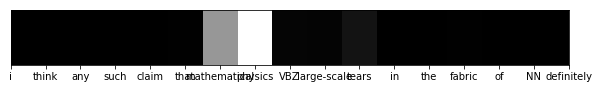

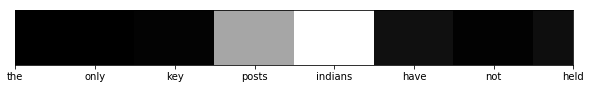

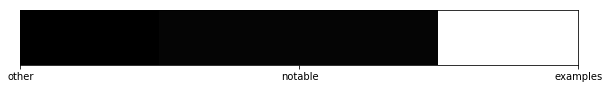

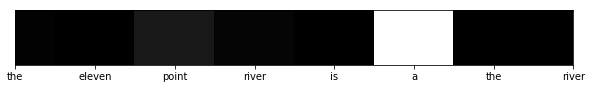

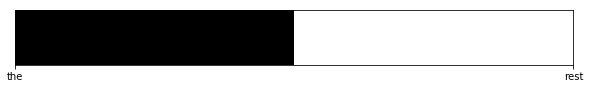

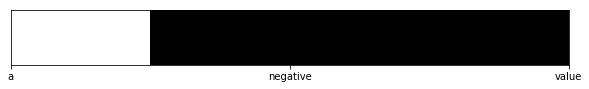

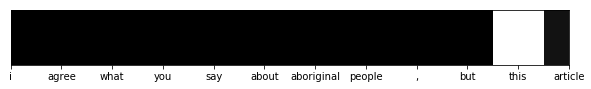

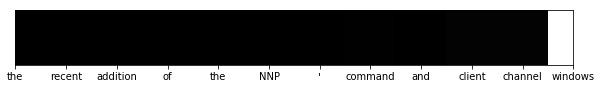

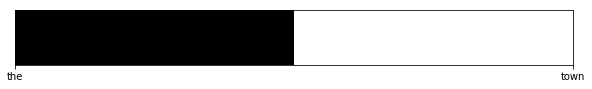

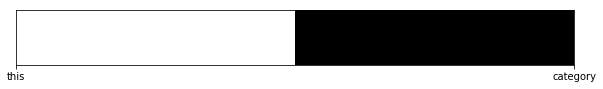

In [286]:
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_attention(text, att_weights):
    
    activation_map = np.transpose(np.expand_dims(att_weights, axis=1))

    #plt.clf()
    f = plt.figure(figsize=(10, 1))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(activation_map, aspect='auto',
                  interpolation='nearest', cmap='gray')

    # add colorbar
    #cbaxes = f.add_axes([0.2, 0.3, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Probability', labelpad=2)

    # add labels
    ax.set_ylim(0,.1)
    ax.set_xlim(0,1)
    ax.set_yticks([], [])
    #ax.set_yticks(range(output_length))
    #ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(len(text)))
    ax.set_xticklabels(text)

    #_ = ax.set_xlabel('Sentence')

    # add grid and legend
    #ax.grid()
    # ax.legend(loc='best')

    #f.savefig(os.path.join(HERE, 'attention_maps', text.replace('/', '')+'.pdf'), bbox_inches='tight')
    #f.show()


np.random.seed(7)
samples = np.random.choice(x_test.shape[0], 10)
for i in samples:
    pred, att = att_model.predict(np.expand_dims(x_test[i], axis=0))
    pred_str = 'VBP' if pred.ravel()[0] < .5 else 'VBZ'
    
    text = data_test[i][1:]
    text_length = len(text)
    att = att[0,-text_length:].ravel()
    
    print('Sentence: ', *[w for w in text], data_test[i][0])
    print('Attention:', att)
    print('Prediction:', pred_str)
    
    visualize_attention(text, att)

In [215]:
score = model.evaluate(x_test, y_test, batch_size=16)
score

4000/4000 [==============================] - 6s 2ms/step


[0.1774557400556514, 0.92900000000000005]